### **Assignment #5**

In this assignment, you will learn about gradient boosting. Write the code for gradient boosting of trees for solving a binary classification problem from scratch. You can use the tree implementation you programmed in Assignment 4 or the Scikit-learn implementation. The trees have to be weak learners, so their depth has to be set
to a small value. You can choose their final depth arbitrarily. Think about overfitting.
Download the dataset on Ucilnica "wine-quality.csv". This is the same dataset as used in Assignment 3, but now we are solving a binary
classification problem (quality is the target and is either high or low). Be careful about
continuous and categorical variables.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.ensemble import GradientBoostingClassifier


In [22]:
data_wine = pd.read_csv('wine_quality.csv', delimiter=',')
data_wine.iloc[:,0]
data_wine = data_wine.drop(data_wine[['Unnamed: 0']], axis=1)
#data_wine['intercept'] = 1
data_wine['alcohol_level'] = [1 if e == 'high' else 0 for e in data_wine['alcohol_level']]
data_wine['quality'] = [1 if el >= 7 else 0 for el in data_wine['quality']]
# quality 1-6: LOW, 7-10: HIGH
data_wine.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,quality,alcohol_level
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,0,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,0,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,0,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,0,0


In [23]:
data_wine = data_wine.sample(frac=1).reset_index(drop=True)
features = data_wine.columns.to_list()
split = len(data_wine)*0.7
train = data_wine.loc[:split]
test = data_wine.loc[split:]
x_train = train[features[:-2] + [features[-1]]]
x_test = test[features[:-2] + [features[-1]]]
y_train = train[features[-2]]
y_test = test[features[-2]]
data_wine = data_wine.astype('float64')
x = data_wine[features[:-2] + [features[-1]]]
y = data_wine[features[-2]]

In [24]:
class Boosting:
    def __init__(self, iterations=100, l_rate=0.1, max_depth=2, feat_fraction=0.8):
        self.iterations = iterations
        self.l_rate = l_rate
        self.max_depth = max_depth
        self.feat_fraction = feat_fraction

        self.trees = []

    def fit(self, x, y):
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        odds = np.log(len(y[y == 1]) / len(y[y == 0]))
        self.odds = odds
        probability = expit(odds)

        residuals = y - probability
        tmp = pd.DataFrame()
        tmp['odds'] = np.array([odds]*len(x))
        tmp['probability'] = probability
        for _ in np.arange(self.iterations):
            feats = np.random.choice(x.columns, size=int(len(x.columns)*0.8), replace=False)

            tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(x[feats], residuals)
            #print(residuals[residuals.isna()])
            tmp['node'] = tree.apply(x[feats])
            
            uni, c = np.unique(tmp['node'], return_counts=True)

            # calc residual sums for each node
            sums_per_leaf = {k: e for k, e in zip(uni, c*tree.tree_.value[uni, 0, 0])}

            # calc (probability)*(1-probability) for each sample
            tmp['prob_diff'] = (tmp['probability']*(1-tmp['probability']))

            # calc new probability
            out_vals_per_node = {k: sums_per_leaf[k] / np.sum(tmp[tmp['node'] == k]['prob_diff']) for k in sums_per_leaf}
            # outvalue -> odds -> probability

            map_fun = np.vectorize(lambda node: out_vals_per_node.get(node))    
            tmp['odds'] = tmp['odds'] + self.l_rate * map_fun(tmp['node'])
            tmp['new_prob'] = expit(tmp['odds']) 
            tmp['probability'] = tmp['new_prob']

            # calc new residuals
            residuals = y - tmp['new_prob']

            self.trees.append((tree, out_vals_per_node, feats))
            #print(tmp.head())

    def predict(self, x):
        pred = pd.DataFrame()
        pred['pred'] = np.array([self.odds]*len(x))

        for tree, outs, feats in self.trees:
            pred['node'] = tree.apply(x[feats])
            pred['out'] = [outs[n] for n in pred['node']]
            pred['pred'] = pred['pred'] + self.l_rate * pred['out']

        pred['pred'] = expit(pred['pred'])
        return [1 if e >= 0.5 else 0 for e in pred['pred']]
        #precision_score(y_test, prediction), recall_score(y_test, prediction)

Test different learning rates. What is a good learning rate?


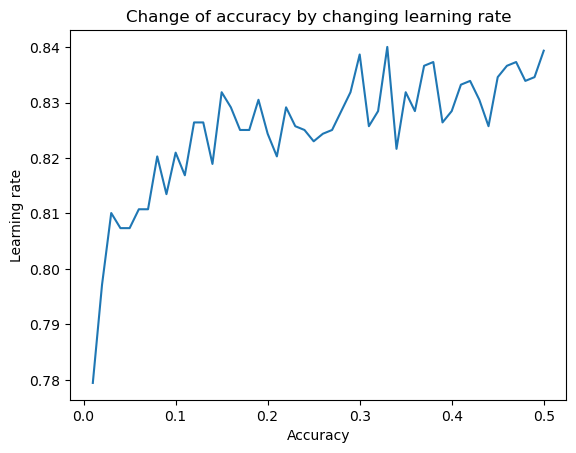

In [25]:
test_lr = []
rates = np.arange(0.01, 0.51, 0.01)
for lr in rates:
    bs = Boosting(iterations=100, l_rate=lr, max_depth=3, feat_fraction=0.8)
    bs.fit(x_train,y_train)
    pred = bs.predict(x_test)
    test_lr.append(accuracy_score(y_test, pred))

plt.plot(rates, test_lr)
plt.title("Change of accuracy by changing learning rate")
plt.xlabel("Accuracy")
plt.ylabel("Learning rate")
plt.show()

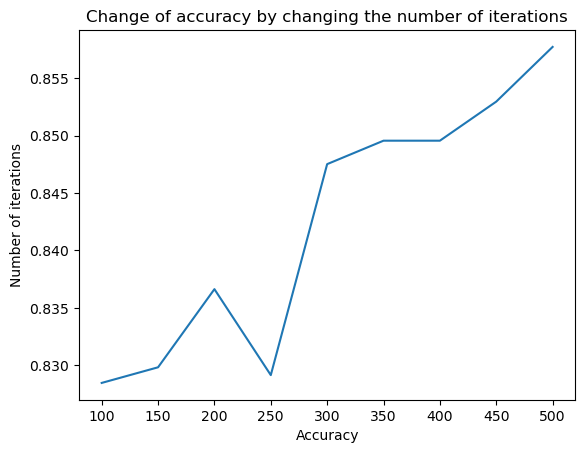

In [26]:
test_iters = []
iters = np.arange(100, 550, 50)
for iter in iters:
    bs = Boosting(iterations=iter, l_rate=0.25, max_depth=3, feat_fraction=0.8)
    bs.fit(x_train,y_train)
    pred = bs.predict(x_test)
    test_iters.append(accuracy_score(y_test, pred))

plt.plot(iters, test_iters)
plt.title("Change of accuracy by changing the number of iterations")
plt.xlabel("Accuracy")
plt.ylabel("Number of iterations")
plt.show()

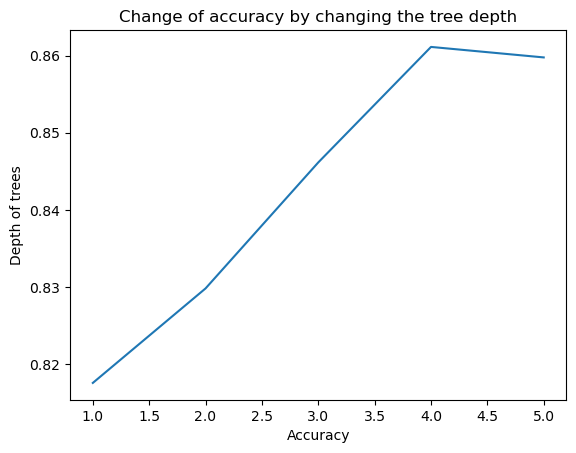

In [27]:
test_depth = []
depths = np.arange(1, 6, 1)
for depth in depths:
    bs = Boosting(iterations=400, l_rate=0.25, max_depth=depth, feat_fraction=0.8)
    bs.fit(x_train,y_train)
    pred = bs.predict(x_test)
    test_depth.append(accuracy_score(y_test, pred))

plt.plot(depths, test_depth)
plt.title("Change of accuracy by changing the tree depth")
plt.xlabel("Accuracy")
plt.ylabel("Depth of trees")
plt.show()

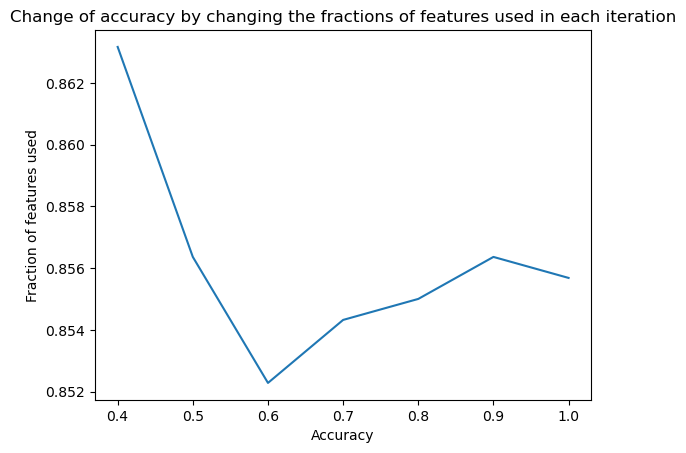

In [28]:
test_frac = []
fracs = np.arange(0.4, 1.1, 0.1)
for frac in fracs:
    bs = Boosting(iterations=400, l_rate=0.25, max_depth=5, feat_fraction=frac)
    bs.fit(x_train,y_train)
    pred = bs.predict(x_test)
    test_frac.append(accuracy_score(y_test, pred))

plt.plot(fracs, test_frac)
plt.title("Change of accuracy by changing the fractions of features used in each iteration")
plt.xlabel("Accuracy")
plt.ylabel("Fraction of features used")
plt.show()

Compare the cross-validation results from your implementation with the "Gradient-BoostingClassifier" classifier implemented in Scikit-learn. Be careful to use the same cross-validation splits in both implementations.

In [29]:
def k_fold(k, X): # returns lists of indexes for folds (train and test)
    n = len(X)

    f_size = n//k

    index_list = [] # n=10, k=5, return: [(2:, :2), (:2 + 4:, 2:4), (:4 + 6:, 4:6), (:6 + 8:, 6:8), (:8, 8:)], where (train, test)

    for i in range(k):
        index_list.append(
            (list(range(0, i*f_size)) + list(range((i+1)*f_size, n)),
             list(range(i*f_size, (i+1)*f_size)))
        )

    return index_list

In [30]:
results = []
for train, test in k_fold(5, x):
    x_train = x.loc[train]
    y_train = y.loc[train]
    x_test = x.loc[test]
    y_test = y.loc[test]
    bs = Boosting(iterations=400, l_rate=0.25, max_depth=3, feat_fraction=0.8)
    bs.fit(x_train, y_train)
    pred = bs.predict(x_test)
    results.append(accuracy_score(y_test, pred))
print(f"Each fold results: {results}\nAverage accuracy: {np.mean(results)}")

Each fold results: [0.8600612870275791, 0.8682328907048008, 0.8692543411644535, 0.8631256384065373, 0.8447395301327886]
Average accuracy: 0.8610827374872321


In [31]:
results = []
for train, test in k_fold(5, x):
    x_train = x.loc[train]
    y_train = y.loc[train]
    x_test = x.loc[test]
    y_test = y.loc[test]
    gbc = GradientBoostingClassifier(n_estimators=400, learning_rate=0.25, max_depth=3, max_features=0.8).fit(x_train, y_train)
    pred = gbc.predict(x_test)
    results.append(accuracy_score(y_test, pred))
print(f"Each fold results: {results}\nAverage accuracy: {np.mean(results)}")

Each fold results: [0.8549540347293156, 0.874361593462717, 0.8794688457609806, 0.8835546475995915, 0.8549540347293156]
Average accuracy: 0.8694586312563841


Try modelling your data also with XGBoost, LightGBM and CatBoost models (fit all
three models). Compare all the models you built. Be careful to evaluate all three
models on the same test dataset. If you make hyperparameter tuning be careful to use a validation set.


In [32]:
import lightgbm as lgb

# Set hyperparameters
params = {
    'objective': 'binary',  # Binary classification problem
    'metric': 'binary_logloss',  # Logarithmic loss for binary classification
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'max_depth': 3,
    'learning_rate': 0.25,  # Step size shrinkage to prevent overfitting
    'feature_fraction': 0.8,  # Randomly select a fraction of features for each iteration
    'verbose': -1
}

# Train the model
num_round = 400  # Number of boosting rounds
results = []
for train, test in k_fold(5, x):
    x_train = x.loc[:train[int(len(train)*0.75)]]
    y_train = y.loc[:train[int(len(train)*0.75)]]

    x_valid = x.loc[train[int(len(train)*0.75):]]
    y_valid = y.loc[train[int(len(train)*0.75):]]

    x_test = x.loc[test]
    y_test = y.loc[test]

    train_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_valid, label=y_valid)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])
    pred = bst.predict(x_test, num_iteration=bst.best_iteration)
    pred = [1 if pre >= 0.5 else 0 for pre in pred]

    results.append(accuracy_score(y_test, pred))

print(f"Each fold results: {results}\nAverage accuracy: {np.mean(results)}")

#print("\nAccuracy:", accuracy_score(y_test, pred))
#print("\nClassification Report:\n", classification_report(y_test, pred))


Each fold results: [0.9856996935648621, 0.9867211440245148, 0.975485188968335, 0.9846782431052093, 0.8355464759959143]
Average accuracy: 0.9536261491317672


In [38]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary:logistic',  # Binary classification problem
    'eval_metric': 'logloss',  # Logarithmic loss for binary classification
    'max_depth': 3,  # Maximum depth of a tree
    'learning_rate': 0.25,  # Step size shrinkage to prevent overfitting
    'colsample_bytree': 0.8,
    'subsample': 1,  # Fraction of samples used for each boosting round
}

# Train the model
num_round = 400  # Number of boosting rounds
results = []
for train, test in k_fold(5, x):
    x_train = x.loc[:train[int(len(train)*0.75)]]
    y_train = y.loc[:train[int(len(train)*0.75)]]

    x_valid = x.loc[train[int(len(train)*0.75):]]
    y_valid = y.loc[train[int(len(train)*0.75):]]

    x_test = x.loc[test]
    y_test = y.loc[test]

    train_data = xgb.DMatrix(x_train, label=y_train)
    val_data = xgb.DMatrix(x_valid, label=y_valid)
    test_data = xgb.DMatrix(x_test, label=y_test)

    bst = xgb.train(params, train_data, num_round, evals=[(val_data, 'eval')], verbose_eval=False)
    pred = bst.predict(test_data)
    pred = [1 if prob >= 0.5 else 0 for prob in pred]
    
    results.append(accuracy_score(y_test, pred))

print(f"Each fold results: {results}\nAverage accuracy: {np.mean(results)}")
#print("Accuracy:", accuracy_score(y_test, y_pred_class))
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, pred))

Each fold results: [0.9856996935648621, 0.9846782431052093, 0.9703779366700716, 0.9836567926455567, 0.8263534218590398]
Average accuracy: 0.9501532175689478

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.93      0.89       748
         1.0       0.68      0.50      0.58       231

    accuracy                           0.83       979
   macro avg       0.77      0.71      0.73       979
weighted avg       0.82      0.83      0.82       979



In [34]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(iterations=400,  # Adjust the number of boosting iterations
                        learning_rate=0.25,  # Adjust the learning rate
                        depth=3,  # Adjust the depth of the trees
                        loss_function='Logloss',  # Use Logloss for binary classification
                        random_seed=42)

results = []
for train, test in k_fold(5, x):
    x_train = x.loc[:train[int(len(train)*0.75)]]
    y_train = y.loc[:train[int(len(train)*0.75)]]

    x_valid = x.loc[train[int(len(train)*0.75):]]
    y_valid = y.loc[train[int(len(train)*0.75):]]

    x_test = x.loc[test]
    y_test = y.loc[test]

    cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), verbose=0)

    pred = cbc.predict(x_test)
        
    results.append(accuracy_score(y_test, pred))

print(f"Each fold results: {results}\nAverage accuracy: {np.mean(results)}")


Each fold results: [0.9244126659856997, 0.9387129724208376, 0.9141981613891726, 0.9284984678243106, 0.8089887640449438]
Average accuracy: 0.902962206332993


In [35]:
# results:
"""                         Average accuracy:
My implementation:          0.8633
Sklearn implementation:     0.8651
Lightgbm implementation:    0.9564
Xgboost implementation:     0.9528
Catboost implementation:    0.9558
"""
pass